In [1]:
import glob
import os

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray as cfxr
import rioxarray as rxr

import xcdat as xc
import xesmf as xe

from cartopy import crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import colormaps as cmo 

import numpy as np
import scipy as sc
import pandas as pd
import geopandas as gpd
import regionmask

from rich import print as rprint
from tqdm.notebook import tqdm
%load_ext rich

In [2]:
tes = gpd.read_file('/home/edskywalker/Documents/Resources/Layers/GOaS_v1_20211214/goas_v01.shp')

tes.head()

,name,latitude,longitude,min_Y,min_X,max_Y,max_X,area_km2,geometry
0,Southern Ocean,-68.03985,-26.63275,-85.56250,-180.00000,-60.00000,180.00000,6793589,"POLYGON ((180.00000 -60.00000, 180.00000 -84.3..."
1,South Atlantic Ocean,-33.73758,-18.83411,-60.00000,-69.60084,0.07511,20.00000,42815540,"MULTIPOLYGON (((-50.68008 0.00000, -50.64339 0..."
2,South Pacific Ocean,-30.09612,-143.06088,-60.00000,130.11129,3.39114,-67.26667,90147400,"MULTIPOLYGON (((-70.93199 -54.75580, -70.92427..."
3,North Pacific Ocean,26.95013,-169.38334,0.00000,117.51622,66.56286,-76.98544,77124830,"MULTIPOLYGON (((157.14844 57.76842, 157.15257 ..."
4,South China and Easter Archipelagic Seas,5.62943,115.46548,-10.92259,95.43328,25.56728,134.03155,6822162,"MULTIPOLYGON (((119.28261 25.48829, 119.27451 ..."


In [3]:
fig, ax = plt.subplots(figsize=[20,6], layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

ini = ax.gridlines(draw_labels = True, alpha=0.5)
ini.top_labels = False
ini.right_labels = False

tes.plot(ax=ax, transform=ccrs.PlateCarree())

In [15]:
#west = 106.7 # 106.3640
#east = 107.1 # 107.1060
#north = -5.85 # -5.1350
#south = -6.15 # -6.1810

# west = 106.8463
# east = 106.9361
# south = -6.1160
# north = -6.0584

west = 106.50
east = 107.10
north = -5.75
south = -6.15

extent = [west, east, south, north]

In [16]:
chlnn = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_nn.nc')

In [17]:
chl_dineof = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/dineof/chlnn_dineof.nc')

rprint(chl_dineof)

<xarray.Dataset> Size: 279MB
Dimensions:  (dim003: 148, dim002: 522, dim001: 451)
Dimensions without coordinates: dim003, dim002, dim001
Data variables:
    chl_nn   (dim003, dim002, dim001) float64 279MB ...

In [18]:
chl_dineofed = chl_dineof.rename(
    {
    'dim001':'lon',
    'dim002':'lat',
    'dim003':'time'
    }
)

chl_dineofed = chl_dineofed.assign_coords(
    lon = chlnn.coords['lon'],
    lat = chlnn.coords['lat'],
    time = chlnn.coords['time']
)

chl_dineofed['chl_nn'].attrs = chlnn['chl_nn'].attrs

'''
dineofed.Oa06.attrs = ref_ori.Oa06.attrs
dineofed.Oa07.attrs = ref_ori.Oa07.attrs
dineofed.Oa08.attrs = ref_ori.Oa08.attrs
dineofed.Oa09.attrs = ref_ori.Oa09.attrs
dineofed.Oa10.attrs = ref_ori.Oa10.attrs
dineofed.Oa11.attrs = ref_ori.Oa11.attrs
dineofed.Oa12.attrs = ref_ori.Oa12.attrs
'''

rprint(chl_dineofed)

<xarray.Dataset> Size: 279MB
Dimensions:  (time: 148, lat: 522, lon: 451)
Coordinates:
  * lon      (lon) float64 4kB 106.2 106.2 106.2 106.2 ... 107.1 107.1 107.1
  * lat      (lat) float64 4kB -5.099 -5.102 -5.104 ... -6.195 -6.197 -6.199
  * time     (time) datetime64[ns] 1kB 2017-11-01 2017-11-15 ... 2023-12-15
Data variables:
    chl_nn   (time, lat, lon) float64 279MB ...

In [19]:
comp = dict(zlib=True, complevel=4, _FillValue=-9999.)

chl_dineofed.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/dineofed_chl.nc',
    format = 'NETCDF4',
    unlimited_dims = 'time',
    encoding = {var: comp for var in chl_dineofed.data_vars}
)

In [20]:
Oa06 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa06.nc')
Oa08 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa08.nc')
Oa12 = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/Oa12.nc')

rdi = ((1 / Oa08['Oa08']) - (1 / Oa06['Oa06'])) * Oa12['Oa12']
rdi = rdi.assign_attrs({'long_name': 'Red Tide Index (RDI)'})

In [21]:
dineof06 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/dineof/06_dineof.nc')
dineof08 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/dineof/08_dineof.nc')
dineof12 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/dineof/12_dineof.nc')

In [22]:
dineofed06 = dineof06.rename(
    {
    'dim001':'lon',
    'dim002':'lat',
    'dim003':'time'
    }
)

dineofed06 = dineofed06.assign_coords(
    lon = Oa06.coords['lon'],
    lat = Oa06.coords['lat'],
    time = Oa06.coords['time']
)

dineofed06['Oa06'].attrs = Oa06['Oa06'].attrs

dineofed08 = dineof08.rename(
    {
    'dim001':'lon',
    'dim002':'lat',
    'dim003':'time'
    }
)

dineofed08 = dineofed08.assign_coords(
    lon = Oa08.coords['lon'],
    lat = Oa08.coords['lat'],
    time = Oa08.coords['time']
)

dineofed08['Oa08'].attrs = Oa08['Oa08'].attrs

dineofed12 = dineof12.rename(
    {
    'dim001':'lon',
    'dim002':'lat',
    'dim003':'time'
    }
)

dineofed12 = dineofed12.assign_coords(
    lon = Oa12.coords['lon'],
    lat = Oa12.coords['lat'],
    time = Oa12.coords['time']
)

dineofed12['Oa12'].attrs = Oa12['Oa12'].attrs


In [23]:
ref_dineofed = [dineofed06['Oa06'],dineofed08['Oa08'],dineofed12['Oa12']]

for lists in ref_dineofed:
    lists.to_netcdf(
        f'/mnt/d/Documents/Programming/Python/Output/IMBER/Data/{lists.name}_dineofed.nc',
        format = 'NETCDF4',
        unlimited_dims = 'time',
        encoding = {f"{lists.name}": {'zlib':True, 'complevel':4, '_FillValue':-9999.0}} # {var: comp for var in ref_resampled.data_vars}
        )

In [24]:
rdidin = ((1 / dineofed08['Oa08']) - (1 / dineofed06['Oa06'])) * dineofed12['Oa12']
rdidin = rdidin.assign_attrs({'long_name': 'Red Tide Index (RDI)'})

In [25]:
chlnn_plot = 10 ** chlnn['chl_nn']
chldin_plot = 10 ** chl_dineofed['chl_nn']


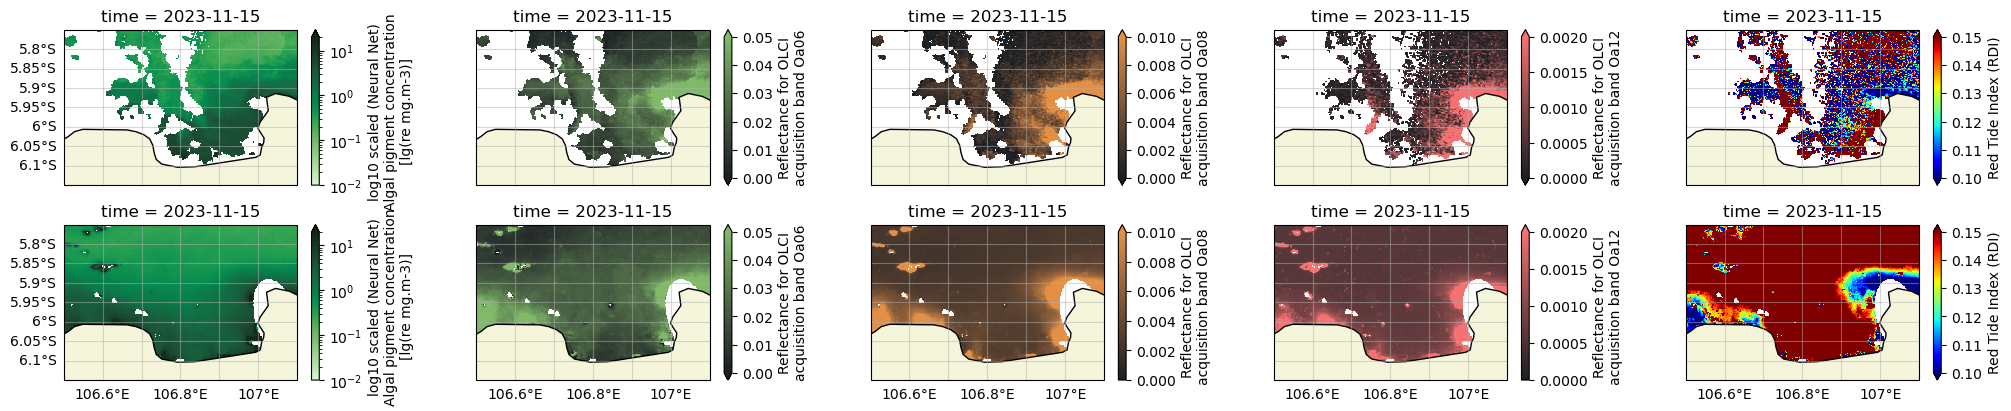

In [26]:
fig, ax = plt.subplots(figsize=[20,4], ncols=5, nrows=2, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(2):
    for j in range(5):
        ax[i,j].set_extent(extent, crs=ccrs.PlateCarree())
        ax[i,j].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

        ini = ax[i,j].gridlines(draw_labels = True, alpha=0.5)
        ini.top_labels = False
        ini.right_labels = False
        if not j == 0:
            ini.left_labels = False
        if not i == 1:
            ini.bottom_labels = False

chlnn_plot.sel(time='2023-11-15').plot(ax=ax[0,0], norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())
chldin_plot.sel(time='2023-11-15').plot(ax=ax[1,0], norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())

Oa06['Oa06'].sel(time='2023-11-15').plot(ax=ax[0,1], norm=colors.Normalize(0,0.05), cmap=cmo.greens_light, zorder=0, transform=ccrs.PlateCarree())
dineofed06['Oa06'].sel(time='2023-11-15').plot(ax=ax[1,1], norm=colors.Normalize(0,0.05), cmap=cmo.greens_light, zorder=0, transform=ccrs.PlateCarree())

Oa08['Oa08'].sel(time='2023-11-15').plot(ax=ax[0,2], norm=colors.Normalize(0,0.01), cmap=cmo.oranges_light, zorder=0, transform=ccrs.PlateCarree())
dineofed08['Oa08'].sel(time='2023-11-15').plot(ax=ax[1,2], norm=colors.Normalize(0,0.01), cmap=cmo.oranges_light, zorder=0, transform=ccrs.PlateCarree())

Oa12['Oa12'].sel(time='2023-11-15').plot(ax=ax[0,3], norm=colors.Normalize(0,0.002), cmap=cmo.reds_light, zorder=0, transform=ccrs.PlateCarree())
dineofed12['Oa12'].sel(time='2023-11-15').plot(ax=ax[1,3], norm=colors.Normalize(0,0.002), cmap=cmo.reds_light, zorder=0, transform=ccrs.PlateCarree())

rdi.sel(time='2023-11-15').plot(ax=ax[0,4], norm=colors.Normalize(0.10,0.15), cmap='jet', zorder=0, transform=ccrs.PlateCarree())
rdidin.sel(time='2023-11-15').plot(ax=ax[1,4], norm=colors.Normalize(0.10,0.15), cmap='jet', zorder=0, transform=ccrs.PlateCarree())

